In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data/train/ad/ad_train_70.jpg
/kaggle/input/train-data/train/ad/ad_train_55.jpg
/kaggle/input/train-data/train/ad/ad_train_68.jpg
/kaggle/input/train-data/train/ad/ad_train_41.jpg
/kaggle/input/train-data/train/ad/ad_train_29.jpg
/kaggle/input/train-data/train/ad/ad_train_50.jpg
/kaggle/input/train-data/train/ad/ad_train_5.jpg
/kaggle/input/train-data/train/ad/ad_train_60.jpg
/kaggle/input/train-data/train/ad/ad_train_2.jpg
/kaggle/input/train-data/train/ad/ad_train_72.jpg
/kaggle/input/train-data/train/ad/ad_train_62.jpg
/kaggle/input/train-data/train/ad/ad_train_14.jpg
/kaggle/input/train-data/train/ad/ad_train_49.jpg
/kaggle/input/train-data/train/ad/ad_train_4.jpg
/kaggle/input/train-data/train/ad/ad_train_9.jpg
/kaggle/input/train-data/train/ad/ad_train_71.jpg
/kaggle/input/train-data/train/ad/ad_train_16.jpg
/kaggle/input/train-data/train/ad/ad_train_44.jpg
/kaggle/input/train-data/train/ad/ad_train_17.jpg
/kaggle/input/train-data/train/ad/ad_train_63.jpg
/kag

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

np.random.seed(3)
tf.compat.v1.set_random_seed(3)


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, fill_mode='nearest')


In [4]:
train_generator = train_datagen.flow_from_directory('../input/train-data/train', 
                                                    target_size=(150,150),
                                                    batch_size=5,
                                                    class_mode='binary')
test_datagen=ImageDataGenerator(rescale=1./255,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                fill_mode='nearest')

test_generator=test_datagen.flow_from_directory('../input/test-data/test', target_size=(150, 150), batch_size=5, class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [5]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [6]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [8]:
history = finetune_model.fit_generator(
       train_generator,
       steps_per_epoch=100,
       epochs=20,
       validation_data=test_generator,
       validation_steps=4)

Epoch 1/20
 32/100 [========>.....................] - 2s 59ms/step - loss: 0.5552 - accuracy: 0.7437 - val_loss: 0.3504 - val_accuracy: 0.9500


In [9]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

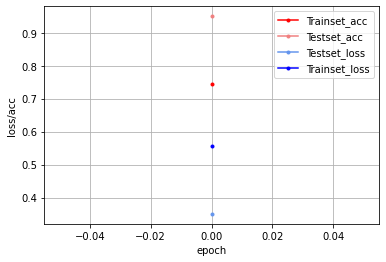

In [13]:

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()
